In [59]:
import ursse.sync_motion_simulation as sms
import pandas as pd
import os 
import numpy as np
from ursse.path_assistant import PathAssistant
from ursse.phase_space_trajectory import get_revolution_delay_df_one_gate
from ursse.data_processing import \
    get_event_delays, plot_arrival_time_hist, get_events_array, get_fanos, \
    plot_fanos_hist, process_file, read_event_delays, save_event_delays
from ursse.time_structure import get_bucket_gates, get_rate_in_gate_Hz,\
    reduce_df_to_one_gate, divide_df_into_time_bins, get_properties_in_time_bins
import matplotlib.pyplot as plt
import valstore as vt

In [3]:
model = sms.Model(rf_noise_std=6e-5)

In [5]:
model.files_and_pars

[{'shift': 'shift_02_28_2020',
  'file': '1el_002.ptu',
  'tau0': None,
  'delta0': None,
  'rand_seed_int': 1,
  'spad_tts_rand_seed': None},
 {'shift': 'shift_02_28_2020',
  'file': '1el_000.ptu',
  'tau0': None,
  'delta0': None,
  'rand_seed_int': 2,
  'spad_tts_rand_seed': None},
 {'shift': 'shift_02_28_2020',
  'file': '1el_001.ptu',
  'tau0': None,
  'delta0': None,
  'rand_seed_int': 3,
  'spad_tts_rand_seed': None},
 {'shift': 'shift_03_05_2020',
  'file': '1el_filters_000.ptu',
  'tau0': None,
  'delta0': None,
  'rand_seed_int': 4,
  'spad_tts_rand_seed': None},
 {'shift': 'shift_03_05_2020',
  'file': '1el_filters_008.ptu',
  'tau0': None,
  'delta0': None,
  'rand_seed_int': 5,
  'spad_tts_rand_seed': None}]

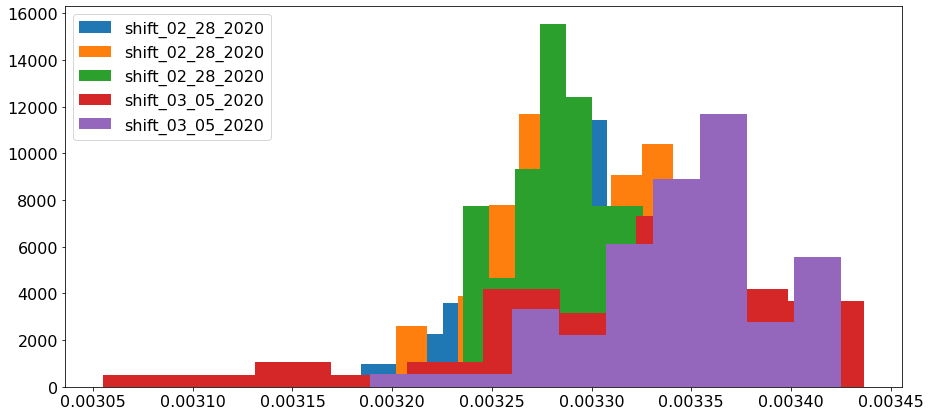

,shift,sample_length_sec,mean,std
0,shift_02_28_2020,59.866547,0.003289,0.000040
1,shift_02_28_2020,19.955523,0.003291,0.000036
2,shift_02_28_2020,19.955485,0.003292,0.000033
3,shift_03_05_2020,19.955516,0.003318,0.000082
4,shift_03_05_2020,29.933286,0.003346,0.000046


In [50]:
n = 10000
show_hist = True
fig, ax = plt.subplots(figsize=(15,7))
results = []
for d in model.files_and_pars:
    gate = (61000, 66000)
    df0, n_revolutions = read_event_delays(
        PathAssistant(d['shift']).get_time_stamp_file_path(d['file']))
    df = reduce_df_to_one_gate(df0, gate).reset_index(drop=True)
    res = df.groupby((df.index/n).astype(int)).apply(lambda a: len(a.index)/(a['revolution'].max()-a['revolution'].min()))
    if show_hist:
        ax.hist(res, density=True, label=d['shift'])
    av, std = res.mean(), res.std()
#     print(d['shift']+" ", f"{133e-9*n_revolutions:.3f}","av = ", av, " std = ", std)
    results.append({"shift": d['shift'], "sample_length_sec": 133e-9*n_revolutions, "mean": av, "std": std})
ax.legend()
plt.show()
res_df = pd.DataFrame(results)
res_df

In [52]:
(lambda x: 100*(x.max()-x.min())/x.mean())(res_df['mean'])

1.7183921294243532

In [63]:
n = 140000
show_hist = False
if show_hist: fig, ax = plt.subplots(figsize=(15,7))
results = []
for d in model.files_and_pars:
    gate = (61000, 66000)
    df0, n_revolutions = read_event_delays(
        PathAssistant(d['shift']).get_time_stamp_file_path(d['file']))
    df = reduce_df_to_one_gate(df0, gate).reset_index(drop=True)
    res = df.groupby((df.index/n).astype(int)).apply(lambda a: len(a.index)/(a['revolution'].max()-a['revolution'].min()))
    if show_hist:
        ax.hist(res, density=True, label=d['shift'])
    av, std = res.mean(), res.std()
#     print(d['shift']+" ", f"{133e-9*n_revolutions:.3f}","av = ", av, " std = ", std)
    results.append({"shift": d['shift'], "sample_length_sec": 133e-9*n_revolutions, "mean": av, "std": std,
                    "n_pieces": int(len(df.index)/n)})
if show_hist:
    ax.legend()
    plt.show()
res_df = pd.DataFrame(results)
res_df

,shift,sample_length_sec,mean,std,n_pieces
0,shift_02_28_2020,59.866547,0.003288,0.000017,10
1,shift_02_28_2020,19.955523,0.003291,0.000009,3
2,shift_02_28_2020,19.955485,0.003289,0.000014,3
3,shift_03_05_2020,19.955516,0.003321,0.000053,3
4,shift_03_05_2020,29.933286,0.003346,0.000020,5


In [100]:
p = res_df.loc[0,"mean"]
vt.newval("p", p, "{:.2e}", "",
          "analyzing_collected_data/all_single_electron_data/av_count_and_noise_analysis.ipynb")
vt.newval("avnRev", 1/p, "{:.0f}", "",
         "analyzing_collected_data/all_single_electron_data/av_count_and_noise_analysis.ipynb")
vt.newval("avcps", 7.5e6*p/1e3, "{:.1f}", "kHz",
         "analyzing_collected_data/all_single_electron_data/av_count_and_noise_analysis.ipynb")

# Noise

In [88]:
shift = PathAssistant('shift_02_28_2020')
df = pd.read_csv(os.path.join(shift.get_shift_cache_folder_path(), "background_000.csv"))
df = df[df['channel'] == 1].drop(columns=['channel']).reset_index(drop=True)

In [102]:
dark_counts = 7.5e6*len(df.index)/df.iloc[-1]['revolution'] # Hz total dark counts
dark_counts

108.2174483231816

In [103]:
vt.newval("DarkCounts", dark_counts, "{:.0f}", "Hz",
         "analyzing_collected_data/all_single_electron_data/av_count_and_noise_analysis.ipynb")

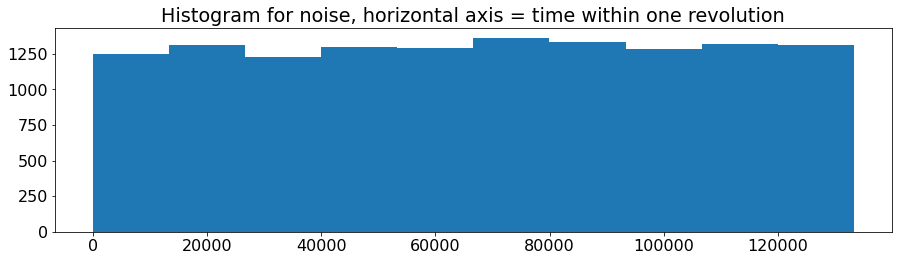

In [92]:
plt.hist(df['delay'])
plt.title("Histogram for noise, horizontal axis = time within one revolution")
plt.show()

In [104]:
dark_counts_gated = 7.5e6*np.sum((df['delay'] > 61000) & (df['delay'] < 66000))/df.iloc[-1]['revolution']
# gated dark counts
dark_counts_gated

4.032430902180298

In [105]:
vt.newval("DarkCountsGated", dark_counts_gated, "{:.1f}", "Hz",
         "analyzing_collected_data/all_single_electron_data/av_count_and_noise_analysis.ipynb")